# Predicting Heart Disease


### Table of contents
* [Introduction](#section_1)
* [Feature Information](#section_2)
* [Preparing the Data](#serction_3)
* [Exploratory Data Analysis](#section_4)
    * [Balance of Class](#section_4.1)
    * [Distribution of Features](#section_4.2)
* [Models](#secton_5)
    * [Random Forest Classifier](#section_5.1)
    * [Linear Classification with Logisitc Regression](#section_5.2)
    


 <a id='secton_1'></a>
### Introduction
The early detection of signs for diseases, can give doctors important insights and increase the chances of finding the right diagnosis. In this project we will use random forests and and logistic regression to potentially predict the presence of heart disease, based on a data set made available by the University of California (UCI).

 The 'Heart Disease Data Set' is publicly available on [Kaggle](https://www.kaggle.com/ronitf/heart-disease-uci) or on the [Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease) of the University of California.
 
 




 <a id='secton_2'></a>
### Feature Information:
- 1 `age`
- 2 `sex`
    - 0 = female
    - 1 = male
- 3 `cp` (chest pain type (4 values))
    - 1 typical angina
    - 2 atypical angina
    - 3 nonanginal pain
    - 4 asymptomatic
- 4 `resting blood pressure` (in mm Hg on admission to the hospital)
- 5 `chol` (serum cholestoral in mg/dl)
- 6 `fbs` (fasting blood sugar over 120mg/dl)
    - 0 = false
    - 1 = true
- 7 `restingecg` (resting electrocardiographic results (values 0, 1, 2))
    - 0: Normal
    - 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
    - 2: showing probable or definite left ventricular hypertrophy by Estes' criteria
- 8 `thalach` (maximum heart rate achieved)
- 9 `exang`(exercise induced angina)
    - 0 = false
    - 1 = true
- 10 `oldpeak` (ST depression induced by exercise relative to rest)
- 11 `slope` (slope of the peak exercise ST segment)
- 12 `ca` (number of major vessels (0-3) colored by flourosopy)
- 13 `thal`
    - 3 = normal
    - 6 = fixed defect
    - 7 = reversable defect
- 14 `target`
    - 0 = absence of heart disease in the patient
    - 1 = presence of heart disease in the patient
 


<a id='section_3'></a>
## Preparing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from scipy.stats import randint as sp_randint

print('Loading dependencies.')


Loading dependencies.


In [3]:
import warnings
warnings.filterwarnings('ignore')


In the data are 13 features of 303 patients and a target variable. The value of the target can be either 1 or 0, depending on the the `presence (target = 1)` or `absence (target = 0)` of heart disease. The 13 features in the data are categorical, like `sex` or levels of `chest pain`, or continuous, like the patients `age` and level of `cholestoral`. 
  



In [4]:
data = pd.read_csv('heart.csv')
print('Shape of the data:\n{}'.format(data.shape))
print('\n\nMissing values per feature:\n\n{}'.format(data.isnull().sum()))
print('\n\nTypes of data after importing the data set:\n\n{}'.format(data.dtypes))


Shape of the data:
(303, 14)


Missing values per feature:

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


Types of data after importing the data set:

age           int64
sex           int64
cp            int64
trestbps      int64
chol          int64
fbs           int64
restecg       int64
thalach       int64
exang         int64
oldpeak     float64
slope         int64
ca            int64
thal          int64
target        int64
dtype: object


Looking for zero values in the continuous features.  
  
  
Continuous features:
- age, trestbps, chol, thalach, oldpeak, ca

Categorical features:
- sex, cp, fbs, restecg, exang, slope, thal


In [5]:
f_cont = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
f_cat = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal']


print('Zero values per continuous feature:\n{}'.format((data[f_cont] == 0).sum()))



Zero values per continuous feature:
age           0
trestbps      0
chol          0
thalach       0
oldpeak      99
ca          175
dtype: int64


In the features `oldpeak` and `ca`, zero is a valid value. But 

In [6]:
print('Incorrect values (\'ca\' = 4) in feature \'ca\':\n{}'.format(data['ca'].loc[data['ca'] == 4].count()))

Incorrect values ('ca' = 4) in feature 'ca':
5


Looking for values which do not correspond to a category in the categorical features. 
  
  For example, the feature `thal` has the categories `normal`, `fixed defect` and `reversable defect`. With the values `3`, `5` and `7` being the placeholder the category. In two rows of the data, the feature `thal` has a value of 0, which is not a category and therefore needs to be treated as missing data.


In [7]:
print('Non-category values in feautre \'thal\':\n{}'.format(data['thal'].loc[data['thal'] == 0].count()))



Non-category values in feautre 'thal':
2


We drop the rows with missing data.
  
  Depending on our results, we might revisit dropping the rows. Other options for handling missing data in categorical features could be to interpret the absence of data as an additional category, use the most common value, or try to predict the value. For now, we will simply drop the affected rows, as this is the easiest and in many cases best way to handle missing data.


In [8]:
data = data.drop(data['thal'].loc[data['thal'] == 0].index)
data = data.drop(data['ca'].loc[data['ca'] == 4].index)



Using one-hot-encoding in the form of the get_dummies function from the pandas library. This step is done to handle categories in our models. We split the non-binbary categorical features into binary features, by creating new features for each category.
  
For example, the feature `restingecg` has three categories. The categories are numbered and correspond to specific states of the resting electrocardiographic results. We create three new features from each category, with the values of either 0 or 1.  



|`restingecg`|  &rarr;|`restingecg_0`|`restingecg_1`|`restingecg_2`|
|---||---|---|---|
|0  |&rarr;|1|0|0|
|1  |&rarr;|0|1|0|
|2  |&rarr;|0|0|1|

In [9]:
features_cat2 = ['cp', 'restecg', 'slope','thal']
data_processed = pd.get_dummies(data, columns=features_cat2)



Renaming the features, to make them more readable and chosing the correct data type for each feature.

In [10]:
data_processed.columns = ['age',
                'sex_male',
                'resting_blood_pressure',
                'serum_cholestoral_in_mg/dl',
                'fasting_blood_sugar_over_120_mgdl',
                'maximum_heart_rate_achieved',
                'exercise_induced_angina',
                'st_depression_induced_by_exercise_relative_to_rest',
                'num_of_major_vessels_colored',
                'target',
                'chest_pain_type_typical_angina',
                'chest_pain_type_atypical_angina',
                'chest_pain_type_non_anginal_pain',
                'chest_pain_type_asymptomatic',
                'resting_ecg_results_normal',
                'resting_ecg_results_having_st_t_wave_abnormality',
                'resting_ecg_results_probable_or_definite_left_ventricular_hypertrophy',
                'slope_upsloping',
                'slope_flat',
                'slope_downsloping',
                'thal_normal',
                'thal_fixed_defect',
                'thal_reversable_defect']


In [11]:
data_processed.sex_male = data_processed.sex_male.astype('category')
data_processed.fasting_blood_sugar_over_120_mgdl = data_processed.fasting_blood_sugar_over_120_mgdl.astype('category')
data_processed.exercise_induced_angina = data_processed.exercise_induced_angina.astype('category')
data_processed.chest_pain_type_typical_angina = data_processed.chest_pain_type_typical_angina.astype('category')
data_processed.chest_pain_type_atypical_angina = data_processed.chest_pain_type_atypical_angina.astype('category')
data_processed.chest_pain_type_non_anginal_pain  = data_processed.chest_pain_type_non_anginal_pain.astype('category')
data_processed.chest_pain_type_asymptomatic = data_processed.chest_pain_type_asymptomatic.astype('category')
data_processed.resting_ecg_results_normal = data_processed.resting_ecg_results_normal.astype('category')
data_processed.resting_ecg_results_having_st_t_wave_abnormality = \
    data_processed.resting_ecg_results_having_st_t_wave_abnormality.astype('category')
data_processed.resting_ecg_results_probable_or_definite_left_ventricular_hypertrophy = \
    data_processed.resting_ecg_results_probable_or_definite_left_ventricular_hypertrophy.astype('category')
data_processed.slope_upsloping = data_processed.slope_upsloping.astype('category')
data_processed.slope_flat = data_processed.slope_flat.astype('category')
data_processed.slope_downsloping = data_processed.slope_downsloping.astype('category')
data_processed.thal_normal = data_processed.thal_normal.astype('category')
data_processed.thal_fixed_defect = data_processed.thal_fixed_defect.astype('category')
data_processed.thal_reversable_defect = data_processed.thal_reversable_defect.astype('category')


In [12]:
data_processed.dtypes


age                                                                         int64
sex_male                                                                 category
resting_blood_pressure                                                      int64
serum_cholestoral_in_mg/dl                                                  int64
fasting_blood_sugar_over_120_mgdl                                        category
maximum_heart_rate_achieved                                                 int64
exercise_induced_angina                                                  category
st_depression_induced_by_exercise_relative_to_rest                        float64
num_of_major_vessels_colored                                                int64
target                                                                      int64
chest_pain_type_typical_angina                                           category
chest_pain_type_atypical_angina                                          category
chest_pain_type_

In [13]:
features_cat = data_processed.loc[:, data_processed.dtypes == 'category'].columns
features_cont = data_processed.loc[:, data_processed.dtypes != 'category'].columns
features_cont = features_cont.drop('target')

In [14]:
data_target = data_processed.loc[data['target'] == 1]
data_nontarget = data_processed.loc[data['target'] == 0]


<a id='section_4'></a> 
## Exploratory data analysis

<a id='section_4.1'></a>
### Balance of classes in the target variable.

In the data, the the presence and absence of heart disease is fairly balanced.

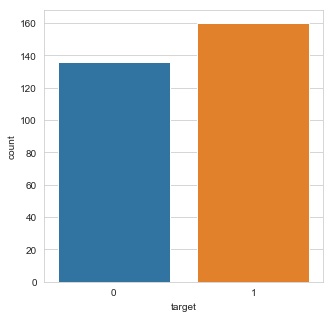

In [15]:
plt.figure(figsize=(5,5))
sns.set_style('whitegrid')
sns.countplot(data['target'])
plt.show()

<a id='section_4.2'></a>
### Distribution of features by target


In [44]:
def plot_distributions_cont(target, nontarget, features):
    i = 0
    plt.figure(figsize=(18, 22))
    for feature in features:
        i += 1
        plt.subplot(6, 2, i)
        sns.distplot(target[feature], color = 'red', hist=True, label='target = 1')
        sns.distplot(nontarget[feature], color = 'blue', hist=True, label='target = 0')
        plt.legend()
    plt.show()
    

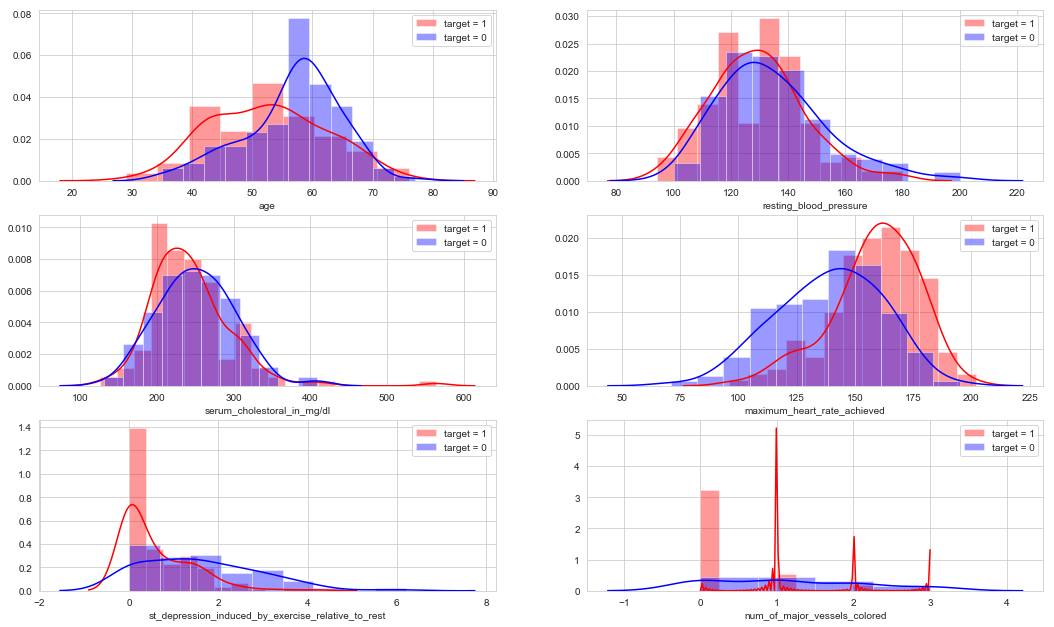

In [45]:
plot_distributions_cont(data_target, data_nontarget, features_cont)



In [18]:
def plot_distributions_count(df, features):
    i = 0
    plt.figure(figsize=(18, 30))
    for feature in features:
        i += 1
        plt.subplot(12, 2, i)
        sns.countplot(y='target', hue=feature, data=df, saturation=0.6)
    plt.show()
    

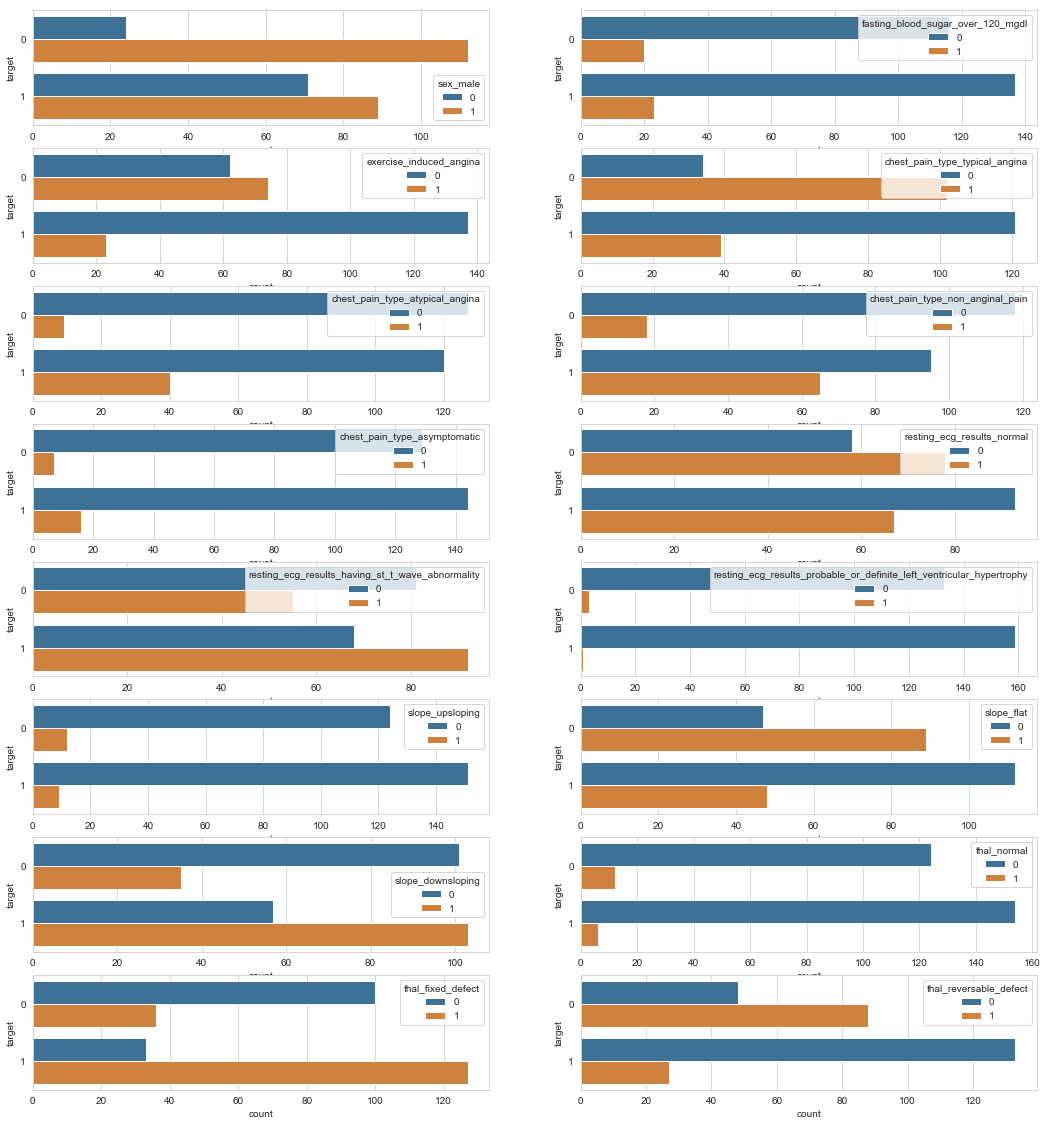

In [19]:
plot_distributions_count(data_processed, features_cat)



<a id='section_5'></a>

## Model
Creating a train and test set. The target feature is roughly balanced, so no need to stratify the data.


In [20]:
X = data_processed.drop(columns='target')
y = data_processed['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)


<a id='section_5.1'></a>

### Random Forest Classifier


Setting parameters for the randomized search.




In [21]:
params_rfc = {'max_depth' : [2, 5],
              'max_features' : sp_randint(1, 22),
              'min_samples_split' : sp_randint(2, 15),
              'min_samples_leaf' : sp_randint(1, 15),
              'bootstrap' : [True, False],
              'n_estimators' : sp_randint(1,30)
              }

In [22]:
%%time

rscv = RandomizedSearchCV(param_distributions=params_rfc, estimator = RandomForestClassifier(), scoring='accuracy',
                          verbose=0, n_iter=100, cv=5, random_state=0)


Wall time: 0 ns


In [23]:
%%time
rscv.fit(X_train, y_train)


Wall time: 14.4 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'max_depth': [2, 5], 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E6490573C8>, 'min_samples_split': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E649057E80>, 'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002E649057940>, 'bootstrap': [True, False], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen obj

In [24]:
print('Score for best accuracy:\n{}'.format(rscv.best_score_))


Score for best accuracy:
0.8738738738738738


In [25]:
print('Parameters for the best score:')
rscv.best_params_


Parameters for the best score:


{'bootstrap': True,
 'max_depth': 5,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 21}

Fitting a random forest classifier with the parameters, that achieved the highest score in the randomized search.

In [26]:
rfc_bp = rscv.best_params_

rfc = RandomForestClassifier(bootstrap=rfc_bp['bootstrap'],
                             max_depth=rfc_bp['max_depth'],
                             max_features=rfc_bp['max_features'],
                             min_samples_leaf=rfc_bp['min_samples_leaf'],
                             min_samples_split=rfc_bp['min_samples_split'],
                             n_estimators=rfc_bp['n_estimators'])

rfc_fitted = rfc.fit(X_train, y_train)

y_predicted = rfc_fitted.predict(X_test)

print('The area under the ROC curve is:\n{}'.format(roc_auc_score(y_test, y_predicted)))



The area under the ROC curve is:
0.798901098901099


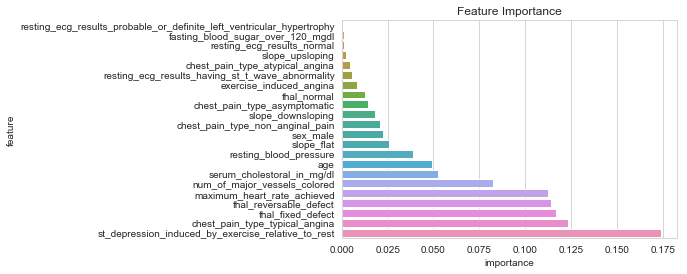

In [27]:
feats = X_train.columns
importance = pd.DataFrame({'importance' : rfc_fitted.feature_importances_, 'feature' :feats})

plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=importance.sort_values(by='importance', ascending=True))
plt.show()



<a id='section_5.2'></a>
### Linear Classification: Logistic Regression
Setting the parameters for a randomized search.


In [28]:
params_lrc = {'penalty' : ['l1', 'l2'],
              'C' : np.geomspace(0.01, 100, 5),
              'class_weight' : [None, 'balanced'],
              }


In [29]:
lr_s = RandomizedSearchCV(param_distributions=params_lrc, estimator=LogisticRegression(), scoring='accuracy', 
                        verbose=0, n_iter=100, cv=5, random_state=0)

In [30]:
%%time
lr_s.fit(X_train, y_train)


Wall time: 1.98 s


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=100, n_jobs=None,
          param_distributions={'penalty': ['l1', 'l2'], 'C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02]), 'class_weight': [None, 'balanced']},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score='warn', scoring='accuracy', verbose=0)

In [31]:
print('Score for best accuracy:\n{}'.format(lr_s.best_score_))


Score for best accuracy:
0.8558558558558559


In [32]:
print('Parameters for the best score:')
lr_s.best_params_


Parameters for the best score:


{'penalty': 'l1', 'class_weight': None, 'C': 1.0}

In [33]:
lr_s_bp = lr_s.best_params_


Fitting a logistic regression model with the parameters, that achieved the highest score in the randomized search.


In [34]:
lr  = LogisticRegression(penalty=lr_s_bp['penalty'],
                         class_weight=lr_s_bp['class_weight'],
                         C=lr_s_bp['C'])


In [35]:
lr_fitted = lr.fit(X_train, y_train)

y_predicted = lr_fitted.predict(X_test)

print('The area under the ROC curve is:\n{}'.format(roc_auc_score(y_test, y_predicted)))



The area under the ROC curve is:
0.8388278388278387


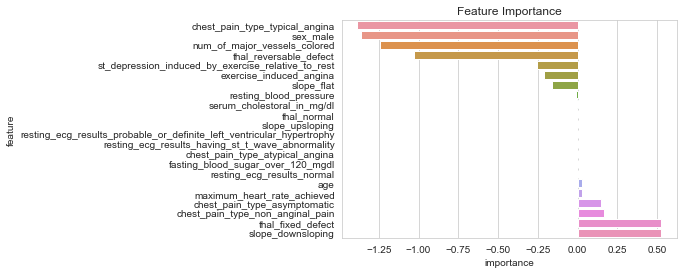

In [36]:
feats = X_train.columns
importance = pd.DataFrame({'importance' : lr_fitted.coef_[0], 'feature' :feats})

plt.title('Feature Importance')
sns.barplot(x='importance', y='feature', data=importance.sort_values(by='importance', ascending=True))
plt.show()


